# Adjoint Modelling Masks for MITgcm
### MITgcm Global Ocean Biogeochemistry Adjoint Simulations
### April 10th, 2024  

&emsp; This notebook prepares relevant masks for the modelling.    

**future update:** Flexible objective function masks.    


In [1]:
import os
import sys

import xarray as xr
import numpy as np
import xmitgcm as xm

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Latitude and Longitude for Plotting
lon = np.linspace(0.0, 360.0, 128) # 2.8125 degrees
lat = np.linspace(-90.0, 90.0, 64) # 2.8125 degrees

#lon = np.linspace(0.0, 360.0, 360) # 1.0 degrees
#lat = np.linspace(-80.0, 80.0, 160) # 1.0 degrees

In [3]:
# %load mds.py
import sys
import re
import glob
import numpy as np
from operator import mul

debug = False

# metafile parsing
# for python2.5
try: next
except NameError:
    def next ( obj ): return obj.next()

_currentline = ''

class ParseError(ValueError):
    def __str__(self):
        metafile = self.args[0]
        lines = self.args[1:]
        try:
            name = metafile.name
        except AttributeError:
            name = metafile

        return '\n'.join(('in metafile: '+name,)
                         + lines
                         + ('in: ' + _currentline,))


# these deal with comments in the metafile
_comment_pattern = re.compile(
        r'//.*?$|/\*.*?\*/|\'(?:\\.|[^\\\'])*\'|"(?:\\.|[^\\"])*"',
        re.DOTALL | re.MULTILINE
    )

def _comment_replacer(match):
    s = match.group(0)
    if s.startswith('/'):
        return ""
    else:
        return s

def strip_comments(text):
    """ strips C and C++ style comments from text """
    return re.sub(_comment_pattern, _comment_replacer, text)


_string_pattern = re.compile(r"'(.*)'$")

def _parse1(s):
    """ convert one item to appropriate type """
    m = _string_pattern.match(s)
    if m:
        s = m.group(1)
        # unquote quotes
        s = re.sub(r"''","'",s)
        return s

    if '.' in s or 'e' in s.lower():
        return float(s)
    else:
        try:
            return int(s)
        except ValueError:
            raise ParseError("Cannot parse value: " + s)


_closing = {'[':']',
            '{':'}',
           }

def parsemeta(metafile):
    """ parses metafile (file object or filename) into a dictionary of lists
        of floats, ints or strings
    """
    global _currentline

    try:
        lines = open(metafile)
    except TypeError:
        lines = iter(metafile)

    d = {}
    for line in lines:
        line = strip_comments(line)
        # skip empty lines
        if re.match(r'\s*$', line):
            continue

        m = re.match(r' *(\w*) *= *(.*?) *$', line)
        if m:
            key,line = m.groups()
        else:
            raise ParseError(metafile,line)

        # look for the opening delimiter ('[' or '{')
        opening = line[0]
        try:
            closing = _closing[opening]
        except KeyError:
            raise ParseError(metafile,line,'Values must be enclosed in [] or {}.')

        # read more lines until a matching closing delimiter is found
        while closing not in line:
            try:
                nextline = next(lines)
            except StopIteration:
                raise ParseError(metafile,line,'No closing ' + closing + ' found.')

            line += ' ' + strip_comments(nextline).rstrip()

        if line[-2:] != closing + ';':
            raise ParseError(metafile,line,
                             'Values must be enclosed in "[ ];" or "{ };".')

        # remove delimiters
        line = line[1:-2].strip(" ,")
        _currentline = line

        if opening == '[':
            # [] can contain any type of values, separated by commas
            val = [ _parse1(s) for s in re.split(r'[, ] *',line) ]
        else:
            # {} can only contain single quote-delimited strings separated by space
            val = [ s.rstrip() for s in re.split(r"'  *'", line.strip("'")) ]

        d[key] = val

    return d

def message(*args):
    sys.stdout.write(' '.join([str(s) for s in args]) + '\n')

def warning(*args):
    sys.stderr.write(' '.join([str(s) for s in args]) + '\n')

def _aslist(i):
    """ if iterable, turn into list, otherwise put into list """
    try:
        res = list(i)
    except TypeError:
        res = [i]
    return res

def fromfileshape(filename,dtype,shape=None,**kwargs):
    return np.fromfile(filename, dtype, **kwargs).reshape(shape)

def scanforfiles(fname):
    """ return list of iteration numbers for which metafiles with base fname exist """
    import glob
    allfiles = glob.glob(fname + '.' + 10*'[0-9]' + '.001.001.meta')
    if len(allfiles) == 0:
        allfiles = glob.glob(fname + '.' + 10*'[0-9]' + '.meta')
        off = -5
    else:
        off = -13

    itrs = [ int(s[off-10:off]) for s in allfiles ]
    itrs.sort()
    return itrs

def readmeta(f):
    """ read meta file and extract tile/timestep-specific parameters """
    meta = parsemeta(f)
    dimList = meta.pop('dimList')
    # pythonize
    gdims = tuple(dimList[-3::-3])
    i0s   = [ i-1 for i in dimList[-2::-3] ]
    ies   = dimList[-1::-3]
    # remove file-specific parameters
    timeInterval = meta.pop('timeInterval', None)
    timeStepNumber = meta.pop('timeStepNumber', None)
    map2gl = meta.pop('map2glob', None)
    # put back only global dimensions
    meta['dimList'] = list(gdims[::-1])
    return gdims,i0s,ies,timeStepNumber,timeInterval,map2gl,meta


_typeprefixes = {'ieee-be':'>',
                 'b'      :'>',
                 '>'      :'>',
                 'ieee-le':'<',
                 'l'      :'<',
                 '<'      :'<',
                }
_typesuffixes = {'float32':'f4',
                 'float64':'f8',
                }


def rdmds(fnamearg,itrs=-1,machineformat='b',rec=None,fill_value=0,
          returnmeta=False,astype=float,region=None,lev=(),
          usememmap=False,mm=False,squeeze=True,verbose=False):
    """
    Read meta-data files as written by MITgcm.

    Call signatures:

        a = rdmds(fname,...)

        a,its,meta = rdmds(fname,...,returnmeta=True)

    Parameters
    ----------
    fname : string
        name of file to read, without the '.data' or '.meta' suffix.  If itrs is
        given, the iteration number is added to `fname` as well.  `fname` may
        contain shell wildcards, which is useful for tile files organized into
        directories, e.g.,

          T = rdmds('prefix*/T', 2880)

        will read prefix0000/T.0000002880.*, prefix0001/T.0000002880.*, ...
        (and any others that match the wildcard, so be careful how you name things!)

    itrs : int or list of ints or np.NaN or np.Inf
        Iteration number(s).  With itrs=-1, will try to read

          fname.meta or fname.001.001.meta, ...

        If itrs is a list of integers of an integer, it will read the corresponding

          fname.000000iter.meta, ...

        If itrs is np.NaN, it will read all iterations for which files are found.
        If itrs is np.Inf, it will read the highest iteration found.

    machineformat : int
        endianness ('b' or 'l', default 'b')
    rec : list of int or None
        list of records to read (default all)
        useful for pickups and multi-field diagnostics files
    fill_value : float
        fill value for missing (blank) tiles (default 0)
    astype : data type
        data type to return (default: double precision)
        None: keep data type/precision of file
    region : tuple of int
        (x0,x1,y0,y1) read only this region (default (0,nx,0,ny))
    lev : list of int or tuple of lists of int
        list of levels to read, or, for multiple dimensions
        (excluding x,y), tuple(!) of lists (see examples below)
    usememmap : bool
        if True, use a memory map for reading data (default False)
        recommended when using lev, or region with global files
        to save memory and, possibly, time

    Returns
    -------
    a : array_like
        numpy array of the data read
    its : list of int
        list of iteration numbers read (only if returnmeta=True)
    meta : dict
        dictionary of metadata (only if returnmeta=True)

    Examples
    --------
    >>> XC = rdmds('XC')
    >>> XC = rdmds('res_*/XC')
    >>> T = rdmds('T.0000002880')
    >>> T = rdmds('T',2880)
    >>> T2 = rdmds('T',[2880,5760])
    >>> T,its = rdmds('T',numpy.Inf)
    >>> VVEL = rdmds('pickup',2880,rec=range(50,100))
    >>> a5 = rdmds('diags',2880,rec=0,lev=[5])
    >>> a = rdmds('diags',2880,rec=0,lev=([0],[0,1,5,6,7]))
    >>> from numpy import r_
    >>> a = rdmds('diags',2880,rec=0,lev=([0],r_[:2,5:8]))  # same as previous
    >>> a = rdmds('diags',2880,rec=0)[0, [0,1,5,6,7], ...]  # same, but less efficient
    >>> a = rdmds('diags',2880)[0, 0, [0,1,5,6,7], ...]     # even less efficient
    """
    import functools
    usememmap = usememmap or mm
    if usememmap:
        readdata = np.memmap
    else:
        readdata = fromfileshape

    # add iteration number to file name unless itrs is -1
    additrs = itrs != -1
    if itrs is np.nan:
        # all iterations
        itrs = scanforfiles(fnamearg)
        if verbose: warning('Reading {0} time levels: '.format(len(itrs)), *itrs)
        returnits = True
        itrsislist = True
    elif itrs is np.inf:
        # last iteration
        itrs = scanforfiles(fnamearg)
        if len(itrs):
            if verbose: warning('Found {0} time levels, reading'.format(len(itrs)), itrs[-1])
        else:
            if verbose: warning('Found 0 time levels for {}'.format(fnamearg))
        itrs = itrs[-1:]
        returnits = True
        itrsislist = False
    else:
        returnits = False
        itrsislist = np.iterable(itrs)

    # always make itrs a list
    itrs = _aslist(itrs)

    allrec = rec is None
    reclist = _aslist(rec)
    if not isinstance(lev,tuple):
        lev = (lev,)
    levs = tuple( _aslist(l) for l in lev )
    levdims = tuple(len(l) for l in levs)
    levinds = np.ix_(*levs)
    nlev = len(levdims)

    if usememmap:
        recsatonce = True
        readdata = np.memmap
    else:
        recsatonce = allrec
        readdata = fromfileshape

    try:
        typepre = _typeprefixes[machineformat]
    except KeyError:
        raise ValueError('Allowed machineformats: ' + ' '.join(_typeprefixes))

    arr = None
    metaref = {}
    timeStepNumbers = []
    timeIntervals = []
    for iit,it in enumerate(itrs):
        if additrs:
            fname = fnamearg + '.{0:010d}'.format(int(it))
        else:
            fname = fnamearg

        metafiles = glob.glob(fname + 2*('.'+3*'[0-9]') + '.meta') or glob.glob(fname+'.meta')
        if len(metafiles) == 0:
            raise IOError('No files found for ' + fname + '.meta')

        if verbose: warning(metafiles[0])

        if debug: warning('Found',len(metafiles),'metafiles for iteration',it)

        for metafile in metafiles:
            gdims,i0s,ies,timestep,timeinterval,map2gl,meta = readmeta(metafile)
            if arr is None:
                # initialize, allocate
                try:
                    dataprec, = meta['dataprec']
                except KeyError:
                    dataprec, = meta['format']
                tp = typepre + _typesuffixes[dataprec]
                size = np.dtype(tp).itemsize
                if astype is None: astype = tp
                recshape = tuple( ie-i0 for i0,ie in zip(i0s,ies) )
                count = functools.reduce(mul, recshape)
                nrecords, = meta['nrecords']
                tileshape = (nrecords,) + recshape
                if allrec:
                    reclist = range(nrecords)
                    recinds = np.s_[:,] + levinds
                else:
                    recinds = np.ix_(reclist, *levs)

                if region is None:
                    ri0,rie,rj0,rje = 0,gdims[-1],0,gdims[-2]
                else:
                    ri0,rie,rj0,rje = region
                    if ri0 < 0: ri0 += gdims[-1]
                    if rie < 0: rie += gdims[-1]
                    if rj0 < 0: rj0 += gdims[-2]
                    if rje < 0: rje += gdims[-2]

                assert nlev+2 <= len(gdims)
                rdims = levdims + gdims[len(levdims):-2] + (rje-rj0,rie-ri0)
                # always include itrs and rec dimensions and squeeze later
                arr = np.empty((len(itrs),len(reclist))+rdims, astype)
                arr[...] = fill_value
                metaref = meta
            else:
                if meta != metaref:
                    raise ValueError('Meta files not compatible')

            datafile = metafile[:-4] + 'data'

            if region is not None:
                if map2gl is None:
                    # overlap of tile with region:
                    i0 = min(rie, max(ri0, i0s[-1]))
                    ie = min(rie, max(ri0, ies[-1]))
                    j0 = min(rje, max(rj0, i0s[-2]))
                    je = min(rje, max(rj0, ies[-2]))
                    # source indices
                    I0 = i0 - i0s[-1]
                    Ie = ie - i0s[-1]
                    J0 = j0 - i0s[-2]
                    Je = je - i0s[-2]
                    # target indices
                    i0s[-1] = i0 - ri0
                    ies[-1] = ie - ri0
                    i0s[-2] = j0 - rj0
                    ies[-2] = je - rj0
                else:
                    raise NotImplementedError('Region selection is not implemented for map2glob != [0,1]')

            sl = tuple( slice(i0,ie) for i0,ie in zip(i0s,ies) )
            if map2gl is None:
                # part of arr that will receive tile (all records)
                arrtile = arr[(iit,slice(None))+sl]
            else:
                ny,nx = arr.shape[-2:]
                i0 = i0s[-1]
                j0 = i0s[-2]
                ie = ies[-1]
                je = ies[-2]
                # "flat" stride for j
                jstride = map2gl[1]*nx + map2gl[0]
                n = (je-j0)*jstride
                # start of a jstride by je-j0 block that contains this tile
                ii0 = min(i0+nx*j0, nx*ny-n)
                # tile starts at ioff+i0
                ioff = nx*j0 - ii0
                # flatten x,y dimensions
                arrflat = arr.reshape(arr.shape[:-2]+(nx*ny,))
                # extract tile
                arrmap = arrflat[...,ii0:ii0+n].reshape(arr.shape[:-2]+(je-j0,jstride))[...,:,ioff+i0:ioff+ie]
                # slice non-x,y dimensions (except records)
                arrtile = arrmap[(iit,slice(None))+sl[:-2]]
                del arrflat,arrmap

            if recsatonce:
                if region is None:
                    arrtile[...] = readdata(datafile, tp, shape=tileshape)[recinds]
                else:
                    if Ie > I0 and Je > J0:
                        if debug: message(datafile, I0,Ie,J0,Je)
                        arrtile[...] = readdata(datafile, tp, shape=tileshape)[recinds + np.s_[...,J0:Je,I0:Ie]]
            else:
                f = open(datafile)
                for irec,recnum in enumerate(reclist):
                    if recnum < 0: recnum += nrecords
                    f.seek(recnum*count*size)
                    if region is None:
                        arrtile[irec] = np.fromfile(f, tp, count=count).reshape(recshape)[levinds]
                    else:
                        if Ie > I0 and Je > J0:
                            if debug: message(datafile, I0,Ie,J0,Je)
                            tilerec = np.fromfile(f, tp, count=count).reshape(recshape)
                            arrtile[irec] = tilerec[levinds + np.s_[...,J0:Je,I0:Ie]]
                f.close()

        if timestep is not None:
            timeStepNumbers.extend(timestep)

        if timeinterval is not None:
            timeIntervals.append(timeinterval)

    # put list of iteration numbers back into metadata dictionary
    if len(timeStepNumbers):
        metaref['timeStepNumber'] = timeStepNumbers

    if len(timeIntervals):
        metaref['timeInterval'] = timeIntervals

    if arr is None:
        arr = np.array([])
    else:
        # squeeze singleton iteration, record and level dimensions like matlab version
        dims = (len(itrs),len(reclist)) + levdims
        if squeeze:
            # squeeze all singleton dimensions
            squeezed = tuple( d for d in dims if d > 1 )
        else:
            # squeeze all that came from scalar arguments
            keepers = [itrsislist, np.iterable(rec)] + [np.iterable(l) for l in lev]
            squeezed = tuple( d for d,keep in zip(dims, keepers) if keep )

        arr = arr.reshape(squeezed+arr.shape[2+nlev:])

    if returnmeta:
        meta = dict((k.lower(),v) for k,v in metaref.items())
        return arr,itrs,meta
#   elif returnits:
#       return arr,itrs
    else:
        return arr


def wrmds(fbase, arr, itr=None, dataprec='float32', ndims=None, nrecords=None,
          times=None, fields=None, simulation=None, machineformat='b',
          deltat=None, dimlist=None):
    '''Write an array to an mds meta/data file set.

    If itr is given, the files will be named fbase.0000000itr.data and
    fbase.0000000itr.meta, otherwise just fbase.data and fbase.meta.

    Parameters
    ----------
    fbase : string
        Name of file to write, without the '.data' or '.meta' suffixes,
        and without the iteration number if itr is give
    arr : array_like
        Numpy array to write
    itr : int or None
        If given, this iteration number will be appended to the file name
    dataprec : string
        precision of resulting file ('float32' or 'float64')
    ndims : int
        number of non-record dimensions; extra (leading) dimensions
        will be folded into 1 record dimension
    nrecords : int
        number of records; will fold as many leading dimensions as
        necessary (has to match shape!)
    times : float or list of floats
        times to write into meta file.  Either a single float or a list
        of two for a time interval
    fields : list of strings
        list of fields
    simulation : string
        string describing the simulation
    machineformat : string
        'b' or 'l' for big or little endian
    deltat : float
        time step; provide in place of either times or itr to have one
        computed from the other
    dimlist : tuple
        dimensions as will be stored in file (only useful when passing
        meta data from an existing file to wrmds as keyword args)
    '''
    if type(dataprec) == type([]): dataprec, = dataprec
    if type(ndims) == type([]): ndims, = ndims
    if type(nrecords) == type([]): nrecords, = nrecords
    if type(simulation) == type([]): simulation, = simulation
    if type(machineformat) == type([]): machineformat, = machineformat
    if type(deltat) == type([]): deltat, = deltat

    tp = _typeprefixes[machineformat]
    try:
        tp = tp + _typesuffixes[dataprec]
    except KeyError:
        raise ValueError("dataprec must be 'float32' or 'float64'.")

    if ndims is None:
        if nrecords is None:
            ndims = min(3,len(arr.shape))
        else:
            # see how many leading dims we need to make up nrecords
            dims = list(arr.shape[::-1])
            n = 1
            while n < nrecords:
                n *= dims.pop()

            assert n == nrecords
            ndims = len(dims)

    dims = arr.shape[-1:-ndims-1:-1]
    nrec = np.prod(arr.shape[:-ndims], dtype=int)
    if nrecords is not None and nrecords != nrec:
        raise ValueError('Shape/nrecords mismatch')
    if dimlist is not None and tuple(dimlist) != dims:
        raise ValueError('Shape/dimlist mismatch: {} vs {}'.format(dims, dimlist))

    if arr.ndim > ndims + 1:
        sys.stderr.write("Warning: folding several dimensions into record dimension.\n")
#      arr = arr.reshape((-1,)+arr.shape[-ndims:])

    if times is not None:
        try:
            iter(times)
        except TypeError:
            times = [ times ]

    if deltat is not None:
        if itr is None:
            itr = int(times[-1]//deltat)
        elif times is None:
            times = [ deltat*itr ]
        else:
            sys.stderr.write('Warning: discarding deltat.\n')

    if itr is not None:
        fbase = fbase + '.{:010d}'.format(itr)

    with open(fbase + '.meta', 'w') as f:
        if simulation is not None:
            f.write(" simulation = { '" + simulation + "' };\n")

        f.write(" nDims = [ {:3d} ];\n".format(ndims))

        if max(dims) < 10000:
            fmt = '{:5d}'
        else:
            fmt = '{:10d}'

        fmt = fmt + ',' + fmt + ',' + fmt

        f.write(" dimList = [\n " +
            ",\n ".join(fmt.format(d,1,d) for d in dims) +
            "\n ];\n")

        # skipping m2gl

        f.write(" dataprec = [ '" + dataprec + "' ];\n")

        f.write(" nrecords = [ {:5d} ];\n".format(nrec))

        if itr is not None:
            f.write(" timeStepNumber = [ {:10d} ];\n".format(itr))

        if times is not None:
            f.write(" timeInterval = [" +
                    "".join("{:20.12E}".format(t) for t in times) +
                    " ];\n")

        if fields is not None:
            nflds = len(fields)
            f.write(" nFlds = [ {:4d} ];\n".format(nflds))
            f.write(" fldList = {\n")
            for row in range((nflds+19)//20):
                for field in fields[20*row:20*(row+1)]:
                    f.write(" '{:<8s}'".format(field))
                f.write("\n")
            f.write(" };\n")

    arr.astype(tp).tofile(fbase + '.data')



In [4]:
# Numpy "fromfile" Function
# Ref: https://github.com/knaughten/mitgcm_python/blob/master/file_io.py
def set_dtype (prec, endian):

    if endian == 'big':
        dtype = '>'
    elif endian == 'little':
        dtype = '<'
    else:
        print('Error (set_dtype): invalid endianness')
        sys.exit()
    if prec == 32:
        dtype += 'f4'
    elif prec == 64:
        dtype += 'f8'
    else:
        print('Error (set_dtype): invalid precision')
        sys.exit()
    return dtype

In [5]:
# Binary precision, big or little endian (MITgcm uses big endian)
# Pickup files and output files have different precision, be cautious!
prec32 = 32
prec64 = 64
endian = 'big'
dtype32 = set_dtype(prec32, endian)
dtype64 = set_dtype(prec64, endian)

### Open Grid Information `grid.nc` (MITgcm 3deg15L)  


In [6]:
# Grid Information, 2.8 degrees, 15 vertical levels
grid_name = 'grid.nc'
ds = xr.open_dataset(grid_name)
ds

<xarray.Dataset>
Dimensions:  (Z: 15, Zp1: 16, Zu: 15, Zl: 15, X: 128, Y: 64, Xp1: 129, Yp1: 65)
Coordinates:
  * Z        (Z) float64 -25.0 -85.0 -170.0 ... -3.575e+03 -4.19e+03 -4.855e+03
  * Zp1      (Zp1) float64 0.0 -50.0 -120.0 ... -3.87e+03 -4.51e+03 -5.2e+03
  * Zu       (Zu) float64 -50.0 -120.0 -220.0 ... -3.87e+03 -4.51e+03 -5.2e+03
  * Zl       (Zl) float64 0.0 -50.0 -120.0 ... -3.28e+03 -3.87e+03 -4.51e+03
  * X        (X) float64 1.406 4.219 7.031 9.844 ... 350.2 353.0 355.8 358.6
  * Y        (Y) float64 -88.59 -85.78 -82.97 -80.16 ... 80.16 82.97 85.78 88.59
  * Xp1      (Xp1) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2 360.0
  * Yp1      (Yp1) float64 -90.0 -87.19 -84.38 -81.56 ... 81.56 84.38 87.19 90.0
Data variables: (12/30)
    RC       (Z) float64 ...
    RF       (Zp1) float64 ...
    RU       (Zu) float64 ...
    RL       (Zl) float64 ...
    drC      (Zp1) float64 ...
    drF      (Z) float64 ...
    ...       ...
    R_low    (Y, X) float64 ...
    Ro_surf  (Y, X) float64 ...
    Depth    (Y, X) float64 ...
    HFacC    (Z, Y, X) float64 ...
    HFacW    (Z, Y, Xp1) float64 ...
    HFacS    (Z, Yp1, X) float64 ...
Attributes: (12/19)
    the_run_name:    Global Ocean Biogeochemistry Model 2.8 degrees 15 vertic...
    MITgcm_version:  checkpoint68s
    build_user:      yokano
    build_host:      bslws01
    build_date:      Sat 17 Feb 17:29:39 GMT 2024
    MITgcm_URL:      http://mitgcm.org
    ...              ...
    nSy:             1
    nPx:             2
    nPy:             2
    Nx:              128
    Ny:              64
    Nr:              15

In [7]:
# Bathymetry, Longitude, Latitude Information
hFacC = ds['HFacC']
xc = ds['XC']
yc = ds['YC']

In [8]:
# Quick Check
print(hFacC)
#print(np.max(hFacC))
#print(np.min(hFacC))

print(xc)
print(yc)

<xarray.DataArray 'HFacC' (Z: 15, Y: 64, X: 128)>
[122880 values with dtype=float64]
Coordinates:
  * Z        (Z) float64 -25.0 -85.0 -170.0 ... -3.575e+03 -4.19e+03 -4.855e+03
  * X        (X) float64 1.406 4.219 7.031 9.844 ... 350.2 353.0 355.8 358.6
  * Y        (Y) float64 -88.59 -85.78 -82.97 -80.16 ... 80.16 82.97 85.78 88.59
Attributes:
    description:  vertical fraction of open cell at cell center
<xarray.DataArray 'XC' (Y: 64, X: 128)>
[8192 values with dtype=float64]
Coordinates:
  * X        (X) float64 1.406 4.219 7.031 9.844 ... 350.2 353.0 355.8 358.6
  * Y        (Y) float64 -88.59 -85.78 -82.97 -80.16 ... 80.16 82.97 85.78 88.59
Attributes:
    description:  X coordinate of cell center (T-P point)
    units:        degree_east
<xarray.DataArray 'YC' (Y: 64, X: 128)>
[8192 values with dtype=float64]
Coordinates:
  * X        (X) float64 1.406 4.219 7.031 9.844 ... 350.2 353.0 355.8 358.6
  * Y        (Y) float64 -88.59 -85.78 -82.97 -80.16 ... 80.16 82.97 85.78 88.59


#### Make `Mask` of Ones for Errfile   
&emsp; Global coarse resolution ocean model, 2.8 degrees, 15 vertical levels.    
**Question:** How does this mask used for optimization?  


In [ ]:
# Mask based on Bathymetry
mask = ds.HFacC < 2 # True and False (but all True in this case)
msk = (hFacC < 2).astype(int)
mask = msk.values

In [ ]:
# Quick Check
print(np.shape(mask))
print(np.max(mask))
print(np.min(mask))

In [ ]:
# Write Mask (wt_ones.data) Binary File
fn1 = 'adjmask/wt_ones.data' # weight with ones for control settings
xm.utils.write_to_binary(mask.flatten(), fn1)

#### Make Cost/Objective Function (`MaskCKT`) for Adjoint Modelling  
&emsp; Global coarse resolution ocean model, 2.8 degrees, 15 vertical levels.    
**Note:** Temporal weighting mask, `maskT` could depend on settings.  


#### An Example for Southern Ocean (2D Mask)  

In [ ]:
# Make Southern Ocean Mask
msk1 = ds.YC >= -85
msk2 = ds.YC <= -30
mskC = msk1 & msk2 # True and False

mskC = mskC.astype(int)
maskC = mskC.values # numpy arrary (2D)

In [ ]:
# Quick Check
print(np.shape(maskC))
print(np.max(maskC))
print(np.min(maskC))

#### An Example for Southern Ocean (3D Mask)  

In [ ]:
# Make Southern Ocean Mask (3D)
maskC3d = mask*maskC
maskC3d[5:14,:,:] = 0.0

In [ ]:
# Quick Check
print(np.shape(maskC3d))
print(np.max(maskC3d))
print(np.min(maskC3d))

In [ ]:
# Target Depth for Plotting
ik = 0

In [ ]:
# Quick Visualization
fig, ax = plt.subplots()

M = maskC3d[ik,:,:]
#M[M == 0.0] = np.nan

p = ax.contourf(lon, lat, M, cmap = 'viridis')
plt.gca().set_facecolor('black') 
cb = plt.colorbar(p)
cb.set_label('Cost Function (3d) Upper 500m: Southern Ocean')

In [ ]:
# Write Mask (maskC) Binary File
fn2 = 'adjmask/maskC'
#xm.utils.write_to_binary(maskC.flatten(), fn2) # cost/objective function mask
xm.utils.write_to_binary(maskC3d.flatten(), fn2) # cost/objective function mask

#### An Example of Vertical MasK (1D Mask): You can set this separately from `maskC`      

In [ ]:
z = ds.RC
msk1 = z > -500
msk2 = z < 0
mskZ = msk1 & msk2

mskZ = mskZ.astype(int)
maskZ = mskZ.values # numpy arrary (1D)

In [ ]:
# Quick Check
print(maskZ)

print(np.shape(maskZ))
print(np.max(maskZ))
print(np.min(maskZ))

In [ ]:
# Write Mask (maskZ) Binary File
fn3 = 'adjmask/maskZ'
xm.utils.write_to_binary(maskZ.flatten(), fn3) # cost/objective function vertical mask

#### An Example of Time Mask (1D Mask): Tied to simulation setup `maskT`      

In [9]:
# Make Time Mask: Design your Adjoint Sensitivity Experiments First
## Monthly averaging frequency, one year cost objective function so twelve weighting (1/12*12)
## 10 years simulation
maskT_10yrs = np.zeros((1, 2*12*10))
maskT_10yrs[0, 108:120] = 1/12
## 2 years simulation
maskT_2yrs = np.zeros((1, 2*12*2))
maskT_2yrs[0, 12:24] = 1/12
## 2 years simulation (+ extra timestep)
maskT_2yrs_ext = np.zeros((1, 2*12*2+2))
maskT_2yrs_ext[0, 12:24] = 1/12

#print(maskT_10yrs)
#print(maskT_2yrs)
print(maskT_2yrs_ext)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
  0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [11]:
# Quick Check
#print(np.shape(maskT_10yrs))
#print(np.max(maskT_10yrs))
#print(np.min(maskT_10yrs))

print(np.shape(maskT_2yrs_ext))
print(np.max(maskT_2yrs_ext))
print(np.min(maskT_2yrs_ext))

(1, 50)
0.08333333333333333
0.0


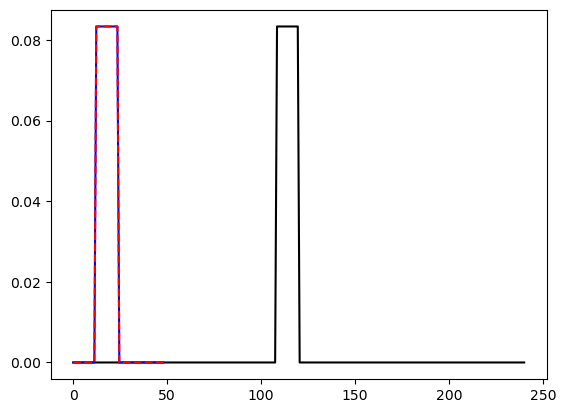

In [16]:
# Visualization: Ocean Time Mask
time_10yrs = np.linspace(0.0, 240, 240)
time_2yrs = np.linspace(0.0, 48, 48)
time_2yrs_ext = np.linspace(0.0, 50, 50)

plt.plot(time_10yrs, maskT_10yrs[0,:], 'k')
plt.plot(time_2yrs, maskT_2yrs[0,:], 'b')
plt.plot(time_2yrs_ext, maskT_2yrs_ext[0,:], 'r--')

In [17]:
# Write Mask (maskT) Binary File
fn4 = 'adjmask/maskT_10yrs'
fn5 = 'adjmask/maskT_2yrs'
fn6 = 'adjmask/maskT_2yrs_ext'
xm.utils.write_to_binary(maskT_10yrs.flatten(), fn4) # cost/objective function mask
xm.utils.write_to_binary(maskT_2yrs.flatten(), fn5) # cost/objective function mask
xm.utils.write_to_binary(maskT_2yrs_ext.flatten(), fn6) # cost/objective function mask

#### Appendix: Ocean Analysis Mask  


In [ ]:
# Make Analysis Mask (Optional)
## Note: No needed for adjoint sensitivity experiments
msk1 = ds.YC >= -65
msk2 = ds.YC <= -30
msk3 = ds.XC >= 180
msk4 = ds.XC <= 250
mskA = msk1 & msk2 & msk3 & msk4

mskA = mskA.astype(int)
maskA = mskA.values # numpy arrary

In [ ]:
# Quick Check
print(np.shape(maskA))
print(np.max(maskA))
print(np.min(maskA))

In [ ]:
# Quick Visualization
fig, ax = plt.subplots()

M = maskA
#M[M == 0.0] = np.nan

p = ax.contourf(lon, lat, M, cmap = 'viridis')
plt.gca().set_facecolor('black') 
cb = plt.colorbar(p)
cb.set_label('Ocean Analysis Mask (2d)')

#### Appendix: Mask from BLING Example  


In [ ]:
# Read Binary File
bin_ones_32b = np.fromfile('ones_32b.bin', dtype = dtype32) # ones_32b.bin from a BLING example, the same as wt_ones.data
print(np.shape(bin_ones_32b))

In [ ]:
# Reshape Numpy Array
np_ones_32b = np.reshape(bin_ones_32b, (15, 64, 128)) # axis order, z, y, x for reshape
print(np.shape(np_ones_32b))

In [ ]:
# Quick Check
print(np.shape(np_ones_32b))
print(np.max(np_ones_32b))
print(np.min(np_ones_32b))

In [ ]:
# Quick Visualization
fig, ax = plt.subplots()

#N = mask
N = np_ones_32b
#N[N == 0.0] = np.nan

p = ax.contourf(lon, lat, N[0,:,:], cmap = 'viridis')
plt.gca().set_facecolor('black') 
cb = plt.colorbar(p)
cb.set_label('Ocean Analysis Mask (2d) from BLING Example')

#### Appendix: Mask from Oxygen Adjoint   


In [ ]:
# Read Binary File
bin_msk_etpT = np.fromfile('adjmask/msk_etpT', dtype = dtype32) # ones_32b.bin from a BLING example, the same as wt_ones.data
print(np.shape(bin_msk_etpT))

In [ ]:
# Quick Check
print(bin_msk_etpT)

print(np.shape(bin_msk_etpT))
print(np.max(bin_msk_etpT))
print(np.min(bin_msk_etpT))

In [ ]:
# Visualization: Ocean Time Mask
time_10yrs = np.linspace(0.0, 240, 240)

plt.plot(time_10yrs, bin_msk_etpT, 'r')